<a href="https://colab.research.google.com/github/sahaanirbannew/nli_legal_test_coliee_ovgu/blob/master/Sim_neg_Attention_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install tensorflow==1.15
!pip install pyspellchecker

In [0]:
import os 
os.chdir('/content/drive/My Drive/COLIEE/Code/nli_coliee')

In [9]:
import os
import h5py
import datetime
import math
import pickle
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger')
import data_parser_for_simneg as dp


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.contrib import rnn
from keras.utils.np_utils import to_categorical


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Here
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', '

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


	The Google News Dataset is loaded. Model initialising...
Model loaded.


Using TensorFlow backend.


In [0]:
PREPROCESSED_TRAIN_SET = "preprocessed_training_set.json"
PREPROCESSED_REDUCED_TRAIN_SET = "preprocessed_reduced_training_set.json"
PREPROCESSED_VALIDATION_SET = "preprocessed_validation_set.json"
SAVE_MODEL_TO = "models/sim_neg/attention/"
SAVE_STATES_TO = "states/sim_neg/attention/states.hdf5"
SAVE_SCORES_TO = "attention_scores/attention_scores_baseline.pkl"
SAVE_LOGS_TO = "tensorBoardLogs/sim_neg/attention/"
TRAINING_LOG = "logs/sim_neg/attention/training_performance_log.txt"


In [11]:

CUSTOM_VALIDATION = False

if not CUSTOM_VALIDATION:
    X_train, y_train_labels = dp.get_data(PREPROCESSED_TRAIN_SET)
    y_train = to_categorical(y_train_labels)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=5, stratify=y_train)
else:
    X_train, y_train_labels = dp.get_data(PREPROCESSED_REDUCED_TRAIN_SET)
    y_train = to_categorical(y_train_labels)

    # get manually set validation set
    X_val, y_val_labels = dp.get_data(PREPROCESSED_VALIDATION_SET)
    y_val = to_categorical(y_val_labels)

    # Shuffle stratify split training set to get some random instances for validation set
    X_train, X_val_random, y_train, y_val_random = train_test_split(X_train, y_train, test_size=0.1, random_state=10, stratify=y_train)
    # best split seed values: 10
    # bad splits: 58, 14, 94, 31, 24, 4, 95, 59

    # append random instances with custom modelled validation set
    y_val = np.concatenate((y_val, y_val_random))
    X_val = np.concatenate((X_val, X_val_random))

    del y_train_labels, y_val_labels, y_val_random, X_val_random


/content/drive/My Drive/COLIEE/Code/nli_coliee/data_parser_for_simneg.py:66: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  padded_matrix[slices] = matrix[slices]


In [12]:

RAW_TEST_DATA = "dataset/TestData_en.xml"           # set file location to raw test xml
LABELS_FILE = "dataset/test_labels.txt"             # set file location to test labels

if os.path.exists('preprocessed_test_set.json'):
    PREPROCESSED_TEST_SET = "preprocessed_test_set.json"            # Load json dump of test set, uncomment/comment this line 
    print('\nPreprocessed test set loaded.')
else:
    PREPROCESSED_TEST_SET = pre.get_data(RAW_TEST_DATA, "TEST")     # Run preprocessing of test_set
    with open('preprocessed_test_set.json', 'w') as fp:             
        json.dump(PREPROCESSED_TEST_SET, fp)                        # Dump the preprocessed json file
        
    print('\nPreprocessing of Test Set Complete!')
    print('File {} saved to {}'.format('preprocessed_test_set.json',os.getcwd()))

X_test = dp.get_data(PREPROCESSED_TEST_SET, 'TEST')                 # Parse and get X_test data
print('\nTest set parsing complete.')

y_test = []                                                         
with open(LABELS_FILE, "r", errors='ignore') as test_labels:        # Read labels from text file
    for line in test_labels:
        y_test.append(line.split(' ')[1])

y_test = to_categorical(y_test)                                     # Categorize labels into binary format



Preprocessed test set loaded.


/content/drive/My Drive/COLIEE/Code/nli_coliee/data_parser_for_simneg.py:66: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  padded_matrix[slices] = matrix[slices]



Test set parsing complete.


In [0]:
# Training Parameters
learning_rate = 0.000001
num_input = X_train.shape[2]            # dimension of each sentence 
timesteps = X_train.shape[1]            # timesteps
num_hidden = {1: 128, 2: 64}            # dictionary that defines number of neurons per layer 
num_classes = 2                         # total number of classes
num_layers = 1                          # desired number of LSTM layers


In [14]:
# Clears the default graph stack and resets the global default graph. The default graph is a property of the current thread.
# Once a graph is created, all placeholders, variables and any elements are actually part of the current thread.
# If we need to re-execute any of the tensorflow related code again, you need to reset the graph to its default state.
tf.compat.v1.reset_default_graph() 

# Declare placeholders for input and labels that is required for tensor graph
X = tf.compat.v1.placeholder("float", [None, timesteps, num_input])
y = tf.compat.v1.placeholder("float", [None, num_classes])

# initializer = tf.random_normal_initializer(stddev=0.1)
initializer = tf.contrib.layers.xavier_initializer()

fc_weights = {
        'out' : tf.Variable(initializer(([2*num_hidden[1], num_classes])), name='w_out')      # output weights for applying softmax
        }

fc_biases = {
        'out' : tf.Variable(tf.zeros([num_classes]), name='b_out')                # output bias
        }

keep_prob = tf.placeholder(tf.float32, name='keep_prob')
weight_decay = tf.placeholder(tf.float32, name='weight_decay')
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(fc_weights['out']))



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
def BiRNN(x, weights, bias):
    '''
        BiRNN: Defines the architecture of LSTM network for training
        Args: 
                x:          premise_hypothesis pair
                weights:    weights required to apply relu activation function over hidden layer and softmax activation over output layer 
                bias:       bias corresponding to the weights.
        
        Returns:
            1. muladd() applied over last outputs with corresponding weights and bias
            2. concatenated forward and backward cell states
            3. whole rnn output
    '''
    x = tf.unstack(x, timesteps, 1)
    output = x   
    
    for i in range(num_layers):
        
        lstm_fw_cell = rnn.BasicLSTMCell(num_hidden[i+1], forget_bias=1.0 , activation=tf.nn.leaky_relu )          # define forward lstm cell with hidden cells
        lstm_fw_cell = rnn.DropoutWrapper(lstm_fw_cell, output_keep_prob=keep_prob)       # define dropout over hidden forward lstm cell
        lstm_bw_cell = rnn.BasicLSTMCell(num_hidden[i+1], forget_bias=1.0 , activation=tf.nn.leaky_relu)          # define backward lstm cell with hidden cells
        lstm_bw_cell = rnn.DropoutWrapper(lstm_bw_cell,  output_keep_prob=keep_prob)      # define dropout over hidden backward lstm cell
 
        with tf.compat.v1.variable_scope('lstm'+str(i)):
            try:
                output, state_fw, state_bw = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, output, dtype=tf.float32)
            except Exception: # Old TensorFlow version only returns outputs not states
                output = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, output, dtype=tf.float32)
            
            #Venky: concatinating the forward  and the backward cell states of the Rnn cell
            if i == num_layers-1: #last layer
                _ = tf.concat([state_fw.c, state_bw.c], axis=1, name='bidirectional_concat_c')
                _ = tf.concat([state_fw.h, state_bw.h], axis=1, name='bidirectional_concat_h')
            
            # Venky: rnn cell output  --> currently this is not used for LSTMVis
            outputs = tf.unstack(output, timesteps, 0)
            outputs = tf.transpose(outputs, perm=[1, 0, 2]) 
    
    return tf.add(tf.matmul(output[-1], weights['out']), bias['out']), outputs
    


In [16]:
with tf.name_scope("attention"):

    pre_logits , output  = BiRNN(X, fc_weights, fc_biases)
    initializer = tf.random_normal_initializer(stddev=0.1) # he_initializer , xavier_initialiser
    print(output.shape)
    hidden_states = output.shape[2]
    print(hidden_states)
    
    w_hidden = tf.get_variable(name="w_hidden", shape=[hidden_states, timesteps ], initializer=initializer)
    b_hidden = tf.get_variable(name="b_hidden", shape=[timesteps], initializer=initializer)
    w_output = tf.get_variable(name="w_output", shape=[timesteps], initializer=initializer)  
    # adding a one output node in the output layer creates a separate column vector for all the attention weights over which the softmax is applied, that created the problem previously

    score = tf.tanh(tf.tensordot( output, w_hidden, axes=1) + b_hidden)
    # Linear transformation by mulitiplying the weights and the rnn outputs and applying a non linear activtion over this output

    attention = tf.tensordot(score , w_output, axes=1, name='attention')

    attention_score = tf.nn.softmax(attention , name='attention_score') 

    attention_out = tf.reduce_sum( output * tf.expand_dims(attention_score, -1), 1)
    
    print(attention_score.shape)
    print(attention_out.shape)

tf.compat.v1.summary.histogram("attention_score", attention_score)  # write attention score values to tensorboard summary (histogram visualization)


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell, unroll=True))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
(?, 284, 256)
256
(?, 284)
(?, 256)


<tf.Tensor 'attention_score:0' shape=() dtype=string>

In [17]:
with tf.name_scope("output"):
    logits = tf.contrib.slim.fully_connected(attention_out, 2, activation_fn=None)
    prediction = tf.nn.softmax(logits, name='prediction')   # applies softmax over BiRNN output to calculate predicted values
tf.compat.v1.summary.histogram("prediction", prediction)    # write predicted values to tensorboard summary (histogram visualization)


Instructions for updating:
Please use `layer.__call__` method instead.


<tf.Tensor 'prediction:0' shape=() dtype=string>

In [18]:
with tf.name_scope("loss"):
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))      # calculate loss 
    tf.compat.v1.summary.scalar('loss_op', loss_op)                                                 # write loss values to tensorboard summary 
                                                                                                    # (histogram visualization)
    
    reg_losses = tf.compat.v1.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)                              # apply regularizer over output weights
    loss_op = loss_op + weight_decay * tf.add_n(reg_losses)                                                   # add regularization term with loss.
    
    #     optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)                                     # apply Adam Optimizer for loss optimization
    gvs = optimizer.compute_gradients(loss_op)                                                      # fetch gradient values
#     capped_gvs = [(tf.clip_by_value(grad, -0.1, 0.1), var) for grad, var in gvs]                    # clip each gradient value within the limit
    
    train_op = optimizer.apply_gradients(gvs)                                                       # applied clipped gradients
    #     train_op = optimizer.minimize(loss_op)
   


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [19]:
with tf.name_scope("accuracy"):
    correct_predictions = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))                       # obtain correct predictions on comparison with actual labels
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'), name="accuracy")               # mean of correct predictions
tf.compat.v1.summary.scalar('accuracy', accuracy)


<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

In [0]:
def save_LSTM_states(states_inter, state_val, SAVE_STATES_TO):
    '''
    Description:    Saves LSTM states to disk
    Input:          1. states_inter: list of states from batch inputs. Eg: If number_of_batches = 4, len(states_inter) = 4
                    2. state_val: list of states from validation input
                    3. SAVE_STATES_TO: location where the states file have to saved to
    Output:         HDF5 file of lstm states saved to SAVE_STATES_TO location
    '''
    final_states = []
    states_inter = np.vstack(states_inter)
    final_states.append(states_inter)                       # append training_states to final_states
    final_states.append(np.array(state_val))                # append validation_states to final_states
    val_1 = final_states[0][0]
    for k in range(len(final_states)):
        for i in range(0,len(final_states[k])):
            temp = final_states[k][i]
            val_1 = np.concatenate((val_1,temp),axis=0)
    print('\nSaving LSTM states...')
    with h5py.File(SAVE_STATES_TO, 'w') as hf:
        hf.create_dataset("d1",  data= val_1)
    print('LSTM states saved to {}'.format(SAVE_STATES_TO))


In [0]:
def plot_confusion(y_test, pred):
    labels = [0, 1]
    cm = confusion_matrix(y_test, pred, labels)
    precision = cm[1][1] / (cm[1][1] + cm[0][1])
    recall = cm[1][1] / (cm[1][1] + cm[1][0])
    print('Confusion Matrix')
    print(cm)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap='summer')

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

    plt.title('Confusion matrix of Baseline')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


--------------------------------------------------
Session started at: 2020-06-09 21:03:15.057889

Start training
(128, 284, 256)
1
1
(128, 284, 256)
2
2
(128, 284, 256)
3
3
(117, 284, 256)
4
4
Epoch 1, Batch Split 4, Minibatch Loss= 2.9249, Minibatch Training Accuracy= 0.444
 Validation Loss = 0.9567, Validation Accuracy= 0.516
(128, 284, 256)
1
1
(128, 284, 256)
2
2
(128, 284, 256)
3
3
(117, 284, 256)
4
4
Epoch 10, Batch Split 4, Minibatch Loss= 2.6168, Minibatch Training Accuracy= 0.444
 Validation Loss = 1.4004, Validation Accuracy= 0.500

 Validation Confusion Matrix: 
Confusion Matrix
[[ 1 63]
 [ 0 62]]
Precision: 0.496
Recall: 1.0


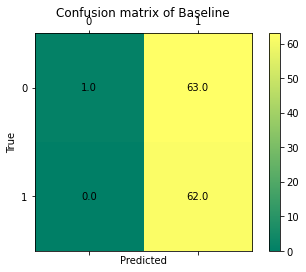

Recording final training and validation states

Saving LSTM states...
LSTM states saved to states/sim_neg/attention/states.hdf5-final.hdf5

Best result: Training acc = 0.4444444477558136, Validation acc = 0.5158730149269104 observed at 1
(501, 284) (126, 284)
Total attention list 2
Training performance: Accuracy 0.4444444477558136, Loss 2.616809368133545
Total Execution time: 2 minutes
Attention scores saved to /content/drive/My Drive/COLIEE/Code/nli_coliee\attention_scores/attention_scores_baseline.pkl
Testing on Test Dataset

Test Loss = 1.3400934934616089, Test Accuracy = 0.4897959232330322
Confusion Matrix
[[ 2 49]
 [ 1 46]]
Precision: 0.4842105263157895
Recall: 0.9787234042553191


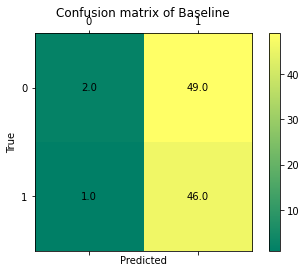

In [22]:
%matplotlib inline 
def run_train(session, train_x, train_y):
    '''
    Description:    Trains the BiLSTM model with given training set in batches and returns final training results and states
    Input:          1. session: Tensorflow session
                    2. train_x: training set of padded premise_hypothesis sequences
                    3. train_y: Two column binary labels that corresponds to the train_x
    Output:         List of training accuracy and loss results, List of final training and validation states
    '''
    print("\nStart training")
    ###################################################
    # initialization of local variables and lists:
    acc_results = []
    loss_results = []
    train_counter = 0
    validation_counter = 0

    training_steps = 10  # epochs
    batch_size = 128        # batch size
    display_step = 10       # displays

    #for early stopping :
    best_loss_val=1000000   # initializing best validation loss to a higher value.
    best_train_acc = 0      # best training accuracy
    last_improvement=0      # a counter which keeps the record of since when (timesteps/iterations) last improvement was seen
    patience= 10            # the number of epochs without improvement you allow before training should be aborted
    # since the values are updated every 10th iteration, the stopping limit becomes: (patience * 10)

    costs = []              # validation costs history
    costs_inter=[]          # intermediate validation costs. These values are only used as a log to keep track of the costs.
    best_loss_observed_epoch = 0

    ###################################################

    session.run(tf.compat.v1.global_variables_initializer())                        # initialize all variables using session
    for epoch in range(1, training_steps + 1):                                      # training iterations
        train_x, train_y = shuffle(train_x, train_y)
        inner_split = train_x.shape[0] // batch_size                                # creating batches
        states_inter = []
        scores_inter = []
        attention_scores = []                                                       # list to append final training and validation attention scores

        for i in range(inner_split + 1):
            batch_x = train_x[i*batch_size:(i+1)*batch_size]                        # generating batches of X_train
            batch_y = train_y[i*batch_size:(i+1)*batch_size]                        # generating batches of y_train
            session.run(train_op, feed_dict={X: batch_x, y: batch_y, keep_prob :0.5, weight_decay:1e-01})

            if epoch == 1 or epoch % display_step == 0:                             # print and save necessary information about training only at an interval of 'display_step' number of steps to reduce computational complexity

                state_train , attention_train  = session.run([output,attention_score], feed_dict={X: batch_x, y: batch_y, keep_prob :0.5, weight_decay:1e-01})     # extract states for each batch-wise training inputs
                # print(state_train.shape)
                states_inter.append(np.array(state_train))
                # print(len(states_inter))
                scores_inter.append(np.array(attention_train))
                # print(len(states_inter))
                if i == inner_split:                                                # last batch split of the selected epoch
                    summary, loss_train, acc_train = session.run([merged, loss_op, accuracy], feed_dict={X: batch_x, y: batch_y, keep_prob :0.5, weight_decay:1e-01})
                    train_writer.add_summary(summary, train_counter)

                    summary, loss_val, acc_val, pred_val ,state_val ,attention_val = session.run([merged, loss_op, accuracy, prediction, output , attention_score ], feed_dict={X: X_val, y: y_val , keep_prob :1.0, weight_decay:0.0})
                    validation_writer.add_summary(summary, validation_counter)
                    train_counter+=display_step
                    validation_counter+=display_step

                    if math.isnan(loss_val):
                        sys.exit("\n!!! Explosion of gradients !!! \nTerminating program!")

                    print("Epoch {}, Batch Split {}".format(epoch, i+1) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss_train) + ", Minibatch Training Accuracy= " + \
                      "{:.3f}".format(acc_train))
                    print(" Validation Loss = {:.4f}".format(loss_val) + ", Validation Accuracy= {:.3f}".format(acc_val))

                    acc_results.append(acc_train)
                    loss_results.append(loss_train)

                    #...... BEGIN EARLY STOPPING EVALUATION ......

                    # CONDITION:
                    # 1. If validation loss has not decreased since 20 steps
                    #   1.1. If the average of last 20 iterations are less than 0.72

                    costs_inter.append(loss_val)            # append validation loss to costs_inter

                    if loss_val < best_loss_val:            # if improved validation loss found
                        best_loss_val = loss_val            # set current validation loss to best_loss_val
                        best_train_acc = acc_train          # set current training accuracy to best_train_acc
                        best_val_acc = acc_val              # set current validation accuracy to acc_val
                        costs +=costs_inter                 # append intermediate cost history to costs
                        last_improvement = 0                # reset last_improvement
                        costs_inter= []                     # reset costs_inter
                        best_loss_observed_epoch = epoch
                    else:
                        last_improvement +=1                # else, increment last_improvement

                    if last_improvement > patience:                         # if no improvement seen over 'patience' number of steps
                        print('\n Validation Confusion Matrix: ')
                        plot_confusion(np.argmax(y_val, axis=1), np.argmax(pred_val, axis=1))
                        print("\nNo improvement found during the last {} iterations".format(patience))
                        print('Avg validation loss over this period: ', sum(costs_inter)/len(costs_inter))

                        _ = saver.save(session, SAVE_MODEL_TO+"m_{}_{}.ckpt".format(acc_train, acc_val), global_step=epoch)

                        print('Recording training and validation states at cost of early-stopping')
                        save_LSTM_states(states_inter, state_val, SAVE_STATES_TO+'-final.hdf5')

                        scores_inter = np.vstack(scores_inter)
                        attention_scores.append(scores_inter)
                        attention_scores.append(np.array(attention_val))

                        return acc_results, loss_results, attention_scores


                    elif epoch % 100 == 0:                                                   # else, save checkpoint and reset costs_inter and last_improvement
                        print('\n Validation Confusion Matrix: ')
                        plot_confusion(np.argmax(y_val, axis=1), np.argmax(pred_val, axis=1))
                        print('\nSaving Checkpoint...')
                        _ = saver.save(session, SAVE_MODEL_TO+"m_{}_{}.ckpt".format(acc_train, acc_val), global_step=epoch)
                        print('<<<Model Checkpoint saved>>>')
                        print('<<<State Checkpoint saved>>>')
                        save_LSTM_states(states_inter, state_val, SAVE_STATES_TO+'-'+str(epoch)+'.hdf5')

                        print('Continuing Training...\n')


                    #...... END EARLY STOPPING EVALUATION ......

                    if epoch == training_steps:                                 # do not change this intendation to make sure this line run only once and not for each split of the epoch!

                        print('\n Validation Confusion Matrix: ')
                        plot_confusion(np.argmax(y_val, axis=1), np.argmax(pred_val, axis=1))

                        _ = saver.save(session, SAVE_MODEL_TO+"m_{}_{}.ckpt".format(acc_train, acc_val), global_step=epoch)                         # save model to local

                        print('Recording final training and validation states')
                        save_LSTM_states(states_inter, state_val, SAVE_STATES_TO+'-final.hdf5')

                        scores_inter = np.vstack(scores_inter)
                        attention_scores.append(scores_inter)
                        attention_scores.append(np.array(attention_val))

                        print('\nBest result: Training acc = {}, Validation acc = {} observed at {}'.format(best_train_acc, best_val_acc, best_loss_observed_epoch)) # the best result seen before 'no improvements'

    print(attention_scores[0].shape, attention_scores[1].shape)
    print("Total attention list " + str(len(attention_scores)))
    return acc_results, loss_results, attention_scores



saver = tf.compat.v1.train.Saver()
saver = tf.compat.v1.train.Saver()
with tf.compat.v1.Session() as sess:
    # Log for tensorboard visualization
    logdir = os.path.join(SAVE_LOGS_TO, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    merged = tf.compat.v1.summary.merge_all()
    train_writer = tf.compat.v1.summary.FileWriter(logdir + '/train', sess.graph)
    validation_writer = tf.compat.v1.summary.FileWriter(logdir + '/validation')

    start_time = datetime.datetime.now()
    print('-'*50)
    print('Session started at: {}'.format(start_time))
    acc_results, loss_results,  attention_scores = run_train(sess, X_train, y_train)
    print('Training performance: Accuracy {}, Loss {}'.format(acc_results[-1], loss_results[-1]))
    end_time = datetime.datetime.now()
    print('Total Execution time: {} minutes'.format(end_time.minute - start_time.minute))

    f = open(SAVE_SCORES_TO,'wb')
    pickle.dump(attention_scores,f)

    print('Attention scores saved to {}\{}'.format(os.getcwd(), SAVE_SCORES_TO))

    print("Testing on Test Dataset")

    loss_test, acc_test , pred_test = sess.run([loss_op, accuracy , prediction], feed_dict={X: X_test, y: y_test, keep_prob :1.0, weight_decay:0.0})

    print('\nTest Loss = {}, Test Accuracy = {}'.format(loss_test, acc_test))
    plot_confusion(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1))

    sess.close()



In [23]:
%load_ext tensorboard
%tensorboard --logdir tensorBoardLogs/sim_neg/attention/